# Compare Different Features: clogD, Lipinski, RDKit Descriptors, Fingerprints, ...

In [1]:
import pandas as pd
from rdkit import Chem

import ml
import utils
from analysis import CV

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import numpy as np

In [3]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

Add Features Calculated with Internal Tools

In [4]:
pix_features = pd.read_csv("../AndroR_4_final_dataset_training_ALL_STD_rdkit_pix_descriptors 2.csv", index_col=0)
andror_df_all = pd.merge(andror_df_all, pix_features, on='flat_smiles', how='inner')
andror_df_all["final class"] = andror_df_all["final class_x"] # due to the merge command, some columns are duplicated and with a suffix

Use the same groups for all trainings

In [5]:
groups = andror_df_all["cluster_065"]

# clogD

In [5]:
splits_clogD, clogD_pipelines = ml.run_or_retrieve_from_disc(
    X=andror_df_all[['logD Prediction 1|logD 7-8']], 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="clogD",
)

In [6]:
CV_clogD = CV(splits_clogD)

# Generate Discriptors

This can take >20 minutes.

In [7]:
# rdkit_descriptors = {}

# for idx, r in tqdm.tqdm(andror_df_all.iterrows(), desc="Calculating RDKit descriptors"):
#     mol = Chem.MolFromSmiles(r["flat_smiles"])
#     if mol is None:
#         print("Error: Invalid SMILES string:", r["flat_smiles"])
#         continue
#     rdkit_descriptors[idx] = pd.Series(Chem.Descriptors.CalcMolDescriptors(mol))

# rdkit_descriptors = pd.DataFrame(rdkit_descriptors).T

In [7]:
# rdkit_descriptors.to_csv("rdkit_descriptors.csv", index=False)
rdkit_descriptors = pd.read_csv("../rdkit_descriptors.csv")

# Lipinski

In [8]:
Lipinski_columns = ["MolWt", "NumHDonors", "NumHAcceptors", "MolLogP"]

In [9]:
splits_Lipinski, _ = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors[Lipinski_columns], 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="Lipinski",
)

In [10]:
CV_Lipinski = CV(splits_Lipinski)

# RDKit descriptors

In [8]:
splits_rdkit_descriptors, pipelines_rdkit_descriptors = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors, 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors",
)

In [9]:
CV_rdkit_descriptors = CV(splits_rdkit_descriptors)

# Fingerprints

In [13]:
andror_df_all = utils.add_fingerprints_to_df(andror_df_all)

In [15]:
# andror_df_all[["flat_smiles"] + utils.FP_COLUMNS].to_csv("AndroR_4_final_fingerprints_ecpf6.csv")

In [14]:
splits_fingerprints, pipelines_fingerprints = ml.run_or_retrieve_from_disc(
    # X=andror_df_all[utils.FP_COLUMNS], 
    X=[],
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="tanimoto_065",
)

In [15]:
CV_fingerprints = CV(splits_fingerprints)

# Fingerprints Top 5

In [16]:
top5_fingerprints = ['fp_650', 'fp_561', 'fp_486', 'fp_659', 'fp_893']
# old CATBOOST top 5: ['fp_561', 'fp_659', 'fp_486', 'fp_893', 'fp_650']

In [17]:
splits_fingerprints_top5, pipelines_fingerprints_top5 = ml.run_or_retrieve_from_disc(
    # X=andror_df_all[top5_fingerprints], 
    X=[],
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="fingerprints_top5",
)

In [18]:
CV_fingerprints_top5 = CV(splits_fingerprints_top5)

# Fingerprints Excl. Top 5

In [19]:
fingerprints_excl_top_5 = [col for col in utils.FP_COLUMNS if col not in top5_fingerprints]

In [20]:
splits_fingerprints_excl_top5, pipelines_fingerprints_excl_top5 = ml.run_or_retrieve_from_disc(
    # X=andror_df_all[fingerprints_excl_top_5], 
    X=[],
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="fingerprints_excl_top5",
)

In [21]:
CV_fingerprints_excl_top5 = CV(splits_fingerprints_excl_top5)

# RDKit Descriptors + Fingerprints

In [22]:
splits_rdkit_descriptors_and_fingerprints, pipelines_rdkit_descriptors_and_fingerprints = ml.run_or_retrieve_from_disc(
    # X=pd.concat([andror_df_all[utils.FP_COLUMNS], rdkit_descriptors], axis=1), 
    X=[],
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors_and_fingerprints",
)

In [23]:
CV_rdkit_descriptors_and_fingerprints = CV(splits_rdkit_descriptors_and_fingerprints)

# RDKit Descriptors + Fingerprints + Pix

In [23]:
pix_columns = [
    'Sol log10 mol/L',
    'Sol mg/L', 
    # 'predominant charge state at pH 7.4',
    # 'predominant charge state at pH 2.0',
    # 'predominant charge state at pH 10.0', 
    'net_charge@pH7.4',
    'net_charge@pH2.0', 'net_charge@pH10.0'
    ]

In [ ]:
splits_rdkit_descriptors_and_fingerprints_and_pix = ml.run_or_retrieve_from_disc(
    X=pd.concat([andror_df_all[utils.FP_COLUMNS + pix_columns], rdkit_descriptors], axis=1), 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_065"], 
    training_name="all_cv_tanimoto065_RDKit_descriptors_and_fingerprints_and_pix",
)

100%|██████████| 5/5 [14:30:06<00:00, 10441.32s/it]


In [ ]:
CV_rdkit_descriptors_and_fingerprints_and_pix = CV(splits_rdkit_descriptors_and_fingerprints_and_pix)

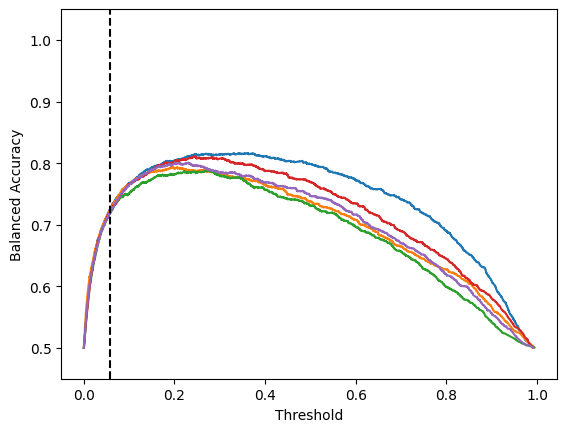

In [ ]:
CV_rdkit_descriptors_and_fingerprints_and_pix.plot_BA()

# Only LogP

In [24]:
splits_MolLogP, _ = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors[["MolLogP"]], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_065"], 
    training_name="MolLogP",
)

In [25]:
CV_MolLogP = CV(splits_MolLogP)

C:\Users\GNZFG\AppData\Local\Temp\ipykernel_15264\366605087.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


(-0.05, 1.05)

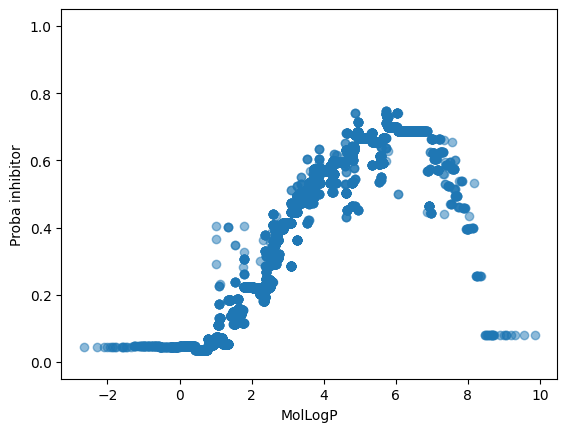

In [22]:
import matplotlib.pyplot as plt
curr_fold = splits_MolLogP[0]
sel_feature = 'MolLogP'

plt.scatter(
    rdkit_descriptors.loc[curr_fold["val_index"]][sel_feature],
    curr_fold["y_hat_proba"][:, 1], 
    # (curr_fold["y"] == "inhibitor").astype(int), 
    cmap='coolwarm', alpha=0.5
)
plt.xlabel(sel_feature)
plt.ylabel("Proba inhibitor")
plt.ylim(-0.05, 1.05)

# Comparison clogD & MolLogP

C:\Users\GNZFG\AppData\Local\Temp\ipykernel_15264\3835019021.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(andror_df_all['logD Prediction 1|logD 7-8'], rdkit_descriptors['MolLogP'], cmap='coolwarm', alpha=0.5)


Text(0, 0.5, 'MolLogP')

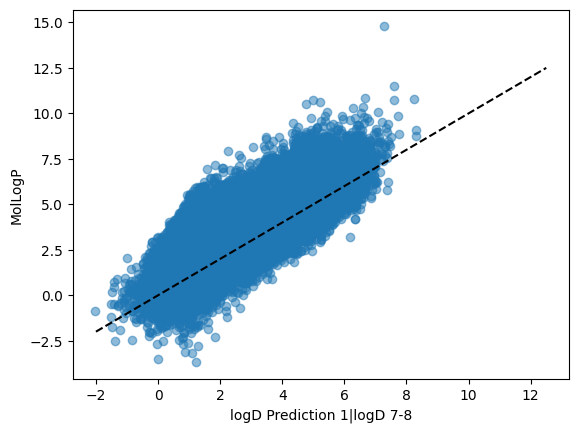

In [23]:
plt.scatter(andror_df_all['logD Prediction 1|logD 7-8'], rdkit_descriptors['MolLogP'], cmap='coolwarm', alpha=0.5)
plt.plot([-2, 12.5], [-2, 12.5], color='black', linestyle='--')
plt.xlabel('logD Prediction 1|logD 7-8')
plt.ylabel('MolLogP')

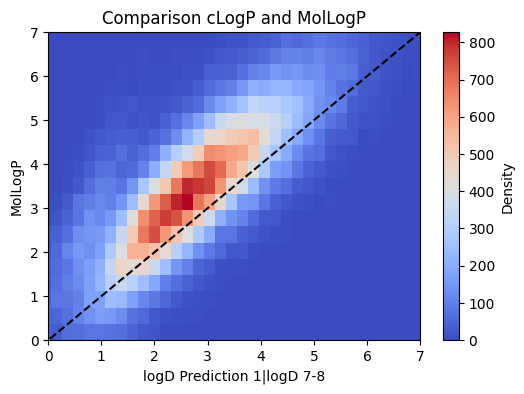

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming andror_df_all and rdkit_descriptors are already defined DataFrames
# Create a 2D histogram
plt.figure(figsize=(6, 4))
plt.hist2d(andror_df_all['logD Prediction 1|logD 7-8'], 
           rdkit_descriptors['MolLogP'], 
           bins=50,  # Number of bins for the histogram
           cmap='coolwarm')

# Add a color bar to indicate density
plt.colorbar(label='Density')

# Plot a reference line
plt.plot([-2, 12.5], [-2, 12.5], color='black', linestyle='--')

# Set labels
plt.xlabel('logD Prediction 1|logD 7-8')
plt.ylabel('MolLogP')

# Show the heatmap
plt.title('Comparison cLogP and MolLogP')
plt.xlim(0, 7)
plt.ylim(0, 7)

plt.show()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


(-0.05, 1.05)

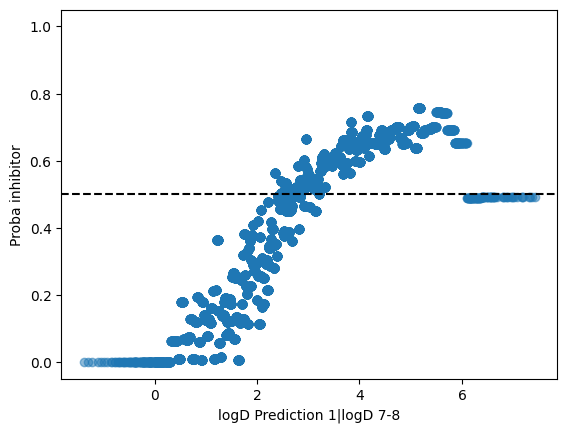

In [ ]:
curr_fold = splits_cLogP[0]
sel_feature = 'logD Prediction 1|logD 7-8'

plt.scatter(
    andror_df_all.loc[curr_fold["val_index"]][sel_feature],
    curr_fold["y_hat_proba"][:, 1], 
    # curr_fold["y_hat"], 
    # (curr_fold["y"] == "inhibitor").astype(int), 
    cmap='coolwarm', alpha=0.5
)
plt.axhline(0.5, color='black', linestyle='--')

plt.xlabel(sel_feature)
plt.ylabel("Proba inhibitor")
# plt.ylabel("Experimental Label Inhibitor")
plt.ylim(-0.05, 1.05)

In [ ]:
import numpy as np

In [ ]:
bucket_width = 0.5
buckets = np.arange(-1, 7.5, bucket_width)

entries_by_bucket = {}
hitrate_by_bucket = {}

for i in range(len(buckets) - 1):
    lower_bound = buckets[i]
    upper_bound = buckets[i + 1]
    
    # Filter the DataFrame for the current bucket
    filtered_df = andror_df_all[
        (andror_df_all['logD Prediction 1|logD 7-8'] >= lower_bound) & 
        (andror_df_all['logD Prediction 1|logD 7-8'] < upper_bound)
    ]
    
    # Calculate the percentage of inhibitors in the current bucket
    if len(filtered_df) > 0:
        percentage_inhibitors = (filtered_df['final class'] == 'inhibitor').mean()

    hitrate_by_bucket[lower_bound] = percentage_inhibitors
    entries_by_bucket[lower_bound] = len(filtered_df)

hitrate_by_bucket = pd.Series(hitrate_by_bucket)
entries_by_bucket = pd.Series(entries_by_bucket)

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Hitrate')

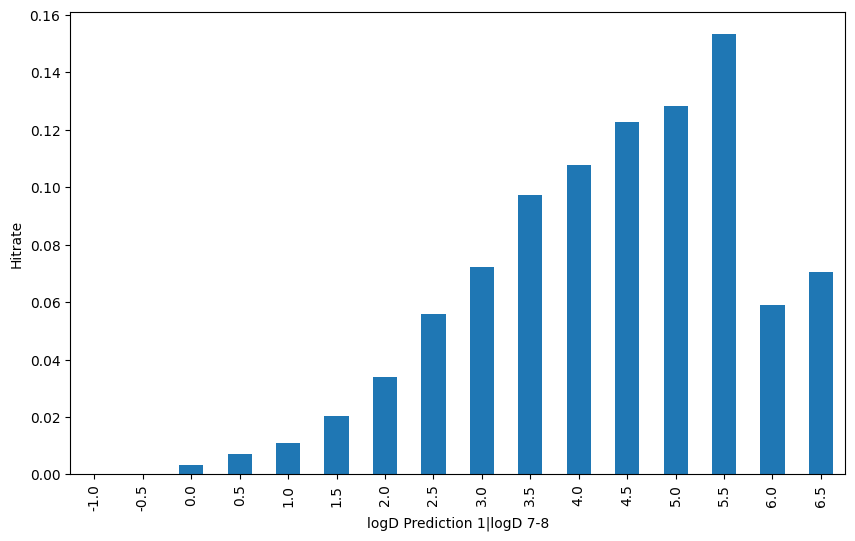

In [ ]:
# add second y-axis, sharing the same x-axis


fig, ax1 = plt.subplots(figsize=(10, 6))


hitrate_by_bucket.plot(kind="bar", ax=ax1)
ax1.set_xlabel('logD Prediction 1|logD 7-8')
ax1.set_ylabel('Hitrate')

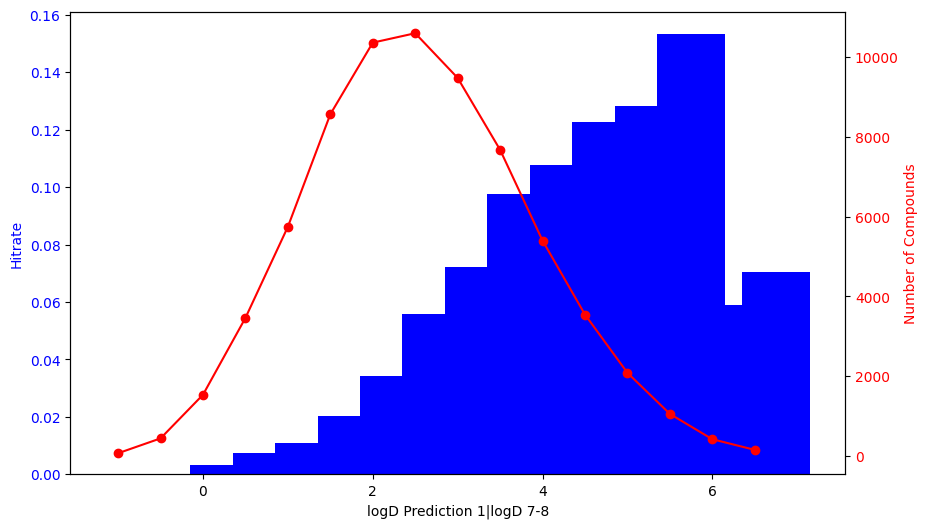

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
x = np.linspace(0, 10, 100)
y1 = np.sin(x)  # First series
y2 = np.exp(x)  # Second series

# Create pandas Series
series1 = entries_by_bucket
series2 = hitrate_by_bucket

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first series
ax1.bar(series2.index + 0.25, series2.values, color='blue', label='Exponential', linestyle='--')
ax1.set_xlabel('logD Prediction 1|logD 7-8')
ax1.set_ylabel('Hitrate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second series
ax2.plot(series1, color='red', label='Sine Wave', marker="o")

ax2.set_ylabel('Number of Compounds', color='red')
ax2.tick_params(axis='y', labelcolor='red')
# Show the plot
plt.show()


# RDKit descriptors excluding MolLogP

In [26]:
splits_rdkit_descriptors_excl_MolLogP, pipelines_rdkit_descriptors_excl_MolLogP = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors.drop(columns=["MolLogP"]), 
    y=andror_df_all["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors_excl_MolLogP",
)

In [27]:
CV_rdkit_descriptors_excl_MolLogP = CV(splits_rdkit_descriptors_excl_MolLogP)

# Murcko Scaffolds

In [ ]:
def get_murcko_from_smiles(smiles_str):
    mol = Chem.MolFromSmiles(smiles_str)
    murcko = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)
    murcko_as_smiles = Chem.MolToSmiles(murcko)
    return murcko_as_smiles

In [ ]:
murcko_smiles = andror_df_all["flat_smiles"].apply(get_murcko_from_smiles)

In [ ]:
andror_df_all["Murcko"] = murcko_smiles

In [ ]:
combined_counts = andror_df_all.groupby(['Murcko', 'cluster_065']).size()

# Filter the DataFrame to keep only rows with non-unique combinations
non_unique_Murcko = andror_df_all[andror_df_all.set_index(['Murcko', 'cluster_065']).index.isin(combined_counts[combined_counts > 1].index)]

In [ ]:
from catboost import CatBoostClassifier
categorical_features = ["Murcko"]
mycatboost = CatBoostClassifier(auto_class_weights='Balanced', verbose=False, cat_features=categorical_features)

In [ ]:
import tqdm

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

PIPELINE_REGISTRY = ml.PIPELINE_REGISTRY

def create_pipeline(cat_features=None):
    return Pipeline(steps=[
        ('classifier', CatBoostClassifier(auto_class_weights='Balanced', verbose=False, cat_features=cat_features)),
])


def run_cv(X, y, groups=None, cv_spec=StratifiedGroupKFold(n_splits=5), training_name=""):
    splits = []
    cat_features = None

    if "Murcko" in X.columns:
        cat_features = ["Murcko"]

    if isinstance(cv_spec, StratifiedGroupKFold):
        split_obj = cv_spec.split(X, y, groups=groups)
    else:
        split_obj = cv_spec.split(X, y)

    for i, indeces in tqdm.tqdm(enumerate(split_obj), total=5):
        train_index, val_index = indeces
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Fit the pipeline
        pipeline = create_pipeline(cat_features)
        PIPELINE_REGISTRY[f"{training_name}_{i}"] = pipeline
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred = pipeline.predict(X_val_fold)
        y_hat_proba = pipeline.predict_proba(X_val_fold)

        splits.append(
            {"y": y_val_fold, 
            "y_hat": y_pred, 
            "y_hat_proba": y_hat_proba, 
            "val_index": val_index})

    return splits

In [ ]:
splits_Murcko = run_cv(
    X=andror_df_all[["Murcko"]], 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_065"], 
    training_name="all_cv_tanimoto065_Murcko",
)

Index(['Murcko'], dtype='object')


100%|██████████| 5/5 [07:58<00:00, 95.70s/it] 


In [ ]:
# with open('splits_Murcko.pickle', 'wb') as f:
#     pickle.dump(splits_Murcko, f)

In [ ]:
with open('splits_Murcko.pickle', 'rb') as f:
    splits_Murcko = pickle.load(f)

In [ ]:
CV_Murcko = CV(splits_Murcko)

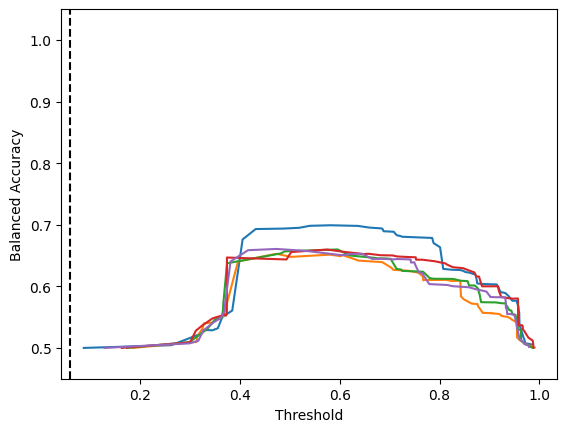

In [ ]:
CV_Murcko.plot_BA()

In [ ]:
CV_Murcko_tanimoto_000 = CV(splits_Murcko_tanimoto_000)

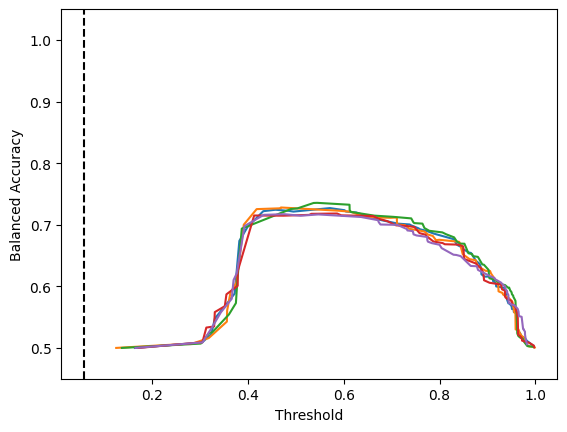

In [ ]:
CV_Murcko_tanimoto_000.plot_BA()

# Compare all results

In [28]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

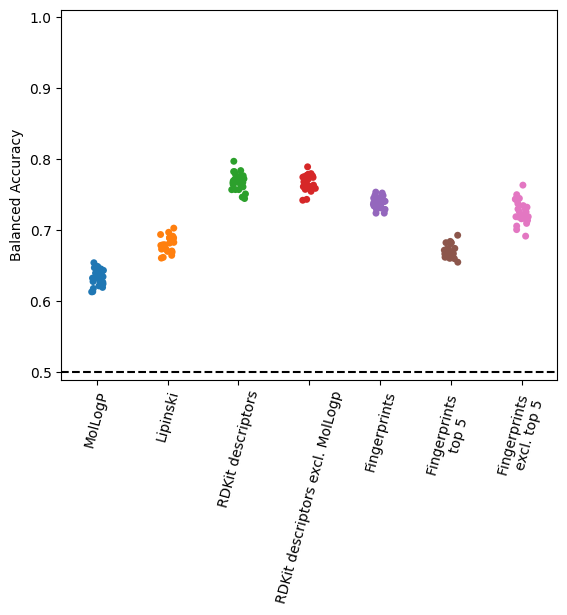

In [31]:
comparison_df = {}

label_threshold = 0.5
sel_metric = balanced_accuracy_score

data_dict = {
    "MolLogP": CV_MolLogP,
    # "cLogD @ pH 7.4": CV_cLogP,
    "Lipinski": CV_Lipinski,
    "RDKit descriptors": CV_rdkit_descriptors,
    "RDKit descriptors excl. MolLogp": CV_rdkit_descriptors_excl_MolLogP,
    "Fingerprints": CV_fingerprints,
    # "RDKit descriptors \n+ fingerprints": CV_rdkit_descriptors_and_fingerprints,
    "Fingerprints \n top 5": CV_fingerprints_top5,
    "Fingerprints \n excl. top 5": CV_fingerprints_excl_top5,
    # "Murcko": CV_Murcko,
    # "Murcko\nrandom CV": CV_Murcko_tanimoto_000,
    # "RDKit descriptors + fingerprints \n + PIx solubility & charge states": CV_rdkit_descriptors_and_fingerprints_and_pix,
}

for feature_list, cv in data_dict.items():
    metric_estimates = [sel_metric(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold) for fold in cv.folds]
    comparison_df[feature_list] = metric_estimates

comparison_df = pd.DataFrame(comparison_df, index=[f"Fold {i+1}" for i in range(len(metric_estimates))])

sns.stripplot(comparison_df)
# rotate xlabels
plt.xticks(rotation=75)

if sel_metric == matthews_corrcoef:
    plt.ylim(-0.1, 1.)
    plt.axhline(0., color='k', linestyle='--')
    plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
elif sel_metric == balanced_accuracy_score:
    plt.ylim(0.49, 1.01)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.ylabel(f"Balanced Accuracy")

In [32]:
performance_by_CV = {}

for i in range(0, 25, 5):
    performance_by_CV[f"CV {i+1}"] = comparison_df.iloc[i:i+5].mean()

In [33]:
performance_by_CV = pd.DataFrame(performance_by_CV).T

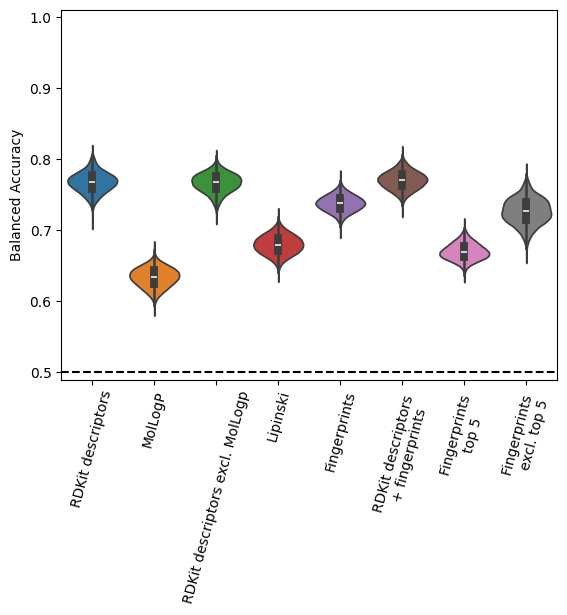

In [29]:
comparison_df = {}

label_threshold = 0.5
sel_metric = "balanced accuracy"
sample_size_posterior = 10000
prior = 1

data_dict = {
    "RDKit descriptors": CV_rdkit_descriptors,
    "MolLogP": CV_MolLogP,
    # "cLogD @ pH 7.4": CV_cLogP,
    "RDKit descriptors excl. MolLogp": CV_rdkit_descriptors_excl_MolLogP,
    "Lipinski": CV_Lipinski,
    "Fingerprints": CV_fingerprints,
    "RDKit descriptors \n+ fingerprints": CV_rdkit_descriptors_and_fingerprints,
    "Fingerprints \n top 5": CV_fingerprints_top5,
    "Fingerprints \n excl. top 5": CV_fingerprints_excl_top5,
}

for feature_list, cv in data_dict.items():
    metric_estimates = []
    for fold in cv.folds:
        curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        metric_estimates += list(curr_samples)
    comparison_df[feature_list] = metric_estimates

comparison_df = pd.DataFrame(comparison_df)

sns.violinplot(comparison_df)
# rotate xlabels
plt.xticks(rotation=75)

if sel_metric == "MCC":
    plt.ylim(-0.1, 1.)
    plt.axhline(0., color='k', linestyle='--')
    plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
elif sel_metric == "balanced accuracy":
    plt.ylim(0.49, 1.01)
    plt.axhline(0.5, color='k', linestyle='--')
    plt.ylabel(f"Balanced Accuracy")
elif sel_metric == "NPV":
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"Negative Predictive Value (NPV)")
elif sel_metric == "PPV":
    plt.ylabel(f"Positive Predictive Value (PPV)")
elif sel_metric == "TPR":
    plt.ylabel(f"True Positive Rate (TPR)")
elif sel_metric == "TNR":
    plt.ylim(0.4, 1.0)
    plt.ylabel(f"True Negative Rate (TNR)")

In [30]:
comparison_df.describe().loc[["mean", "std"]]

,RDKit descriptors,MolLogP,RDKit descriptors excl. MolLogp,Lipinski,Fingerprints,RDKit descriptors \n+ fingerprints,Fingerprints \n top 5,Fingerprints \n excl. top 5
mean,0.767805,0.633809,0.766898,0.679818,0.737950,0.770450,0.670122,0.726901
std,0.014198,0.013604,0.013491,0.013427,0.011409,0.012654,0.011696,0.018422


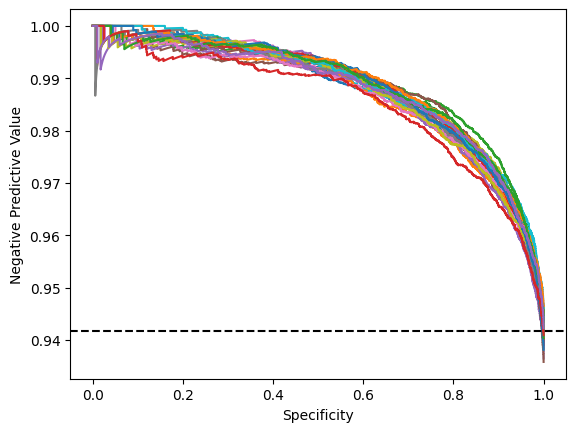

In [10]:
CV_rdkit_descriptors.plot_npv_tnr_curve()

In [36]:
# Calc Performance metrics for one model

In [52]:
cv = CV_rdkit_descriptors


metric_estimates = {}

def append_if_possible(key, curr_samples):
    if key not in metric_estimates:
        metric_estimates[key] = [curr_samples]
    else:
        metric_estimates[key].append(curr_samples)


for fold in cv.folds:
    curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
    TP, FN, FP, TN = curr_cm.flatten()
    tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
    tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
    ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
    npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
    
    curr_samples = (tpr_samples + tnr_samples) / 2
    append_if_possible("BA", curr_samples)

    curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
            (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
    append_if_possible("MCC", curr_samples)
    append_if_possible("NPV", npv_samples)
    append_if_possible("TNR", tnr_samples)
    append_if_possible("TPR", tpr_samples)
    append_if_possible("PPV", ppv_samples)


metric_estimates = pd.DataFrame({k: np.concatenate(v) for k,v in metric_estimates.items()})

In [51]:
metric_estimates.describe().loc[["mean", "std"]]

,BA,MCC,NPV,TNR,TPR,PPV
mean,0.767806,0.286694,0.981422,0.771579,0.764033,0.172114
std,0.014202,0.016802,0.002152,0.009804,0.031047,0.010933


In [61]:
1 - (1 - metric_estimates["NPV"].mean()) / (andror_df_all["final class"] == "inhibitor").mean()

0.6816971750319083

Text(0, 0.5, 'Negative Predictive Value')

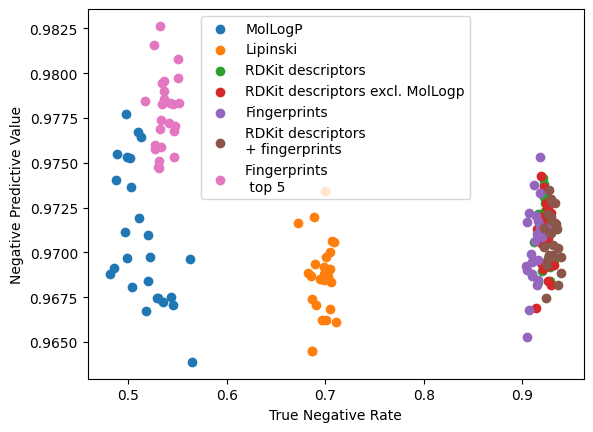

In [ ]:
for feature_list, cv in data_dict.items():
    curr_npv = [precision_score(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, pos_label=False) for fold in cv.folds]
    curr_tnr = [recall_score(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, pos_label=False) for fold in cv.folds]
    plt.scatter(curr_tnr, curr_npv, label=feature_list)

plt.legend()
plt.xlabel("True Negative Rate")
plt.ylabel("Negative Predictive Value")

Text(0, 0.5, 'Precision')

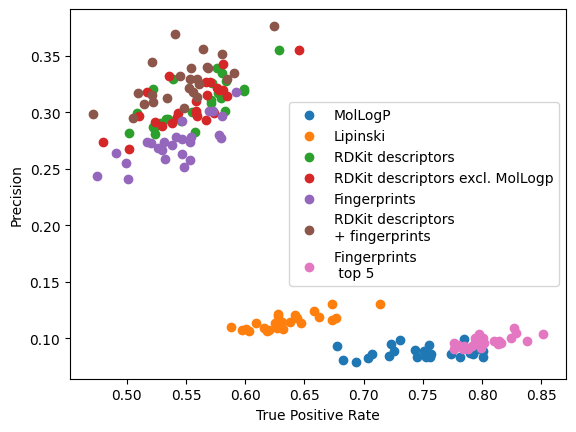

In [67]:
for feature_list, cv in data_dict.items():
    curr_npv = [precision_score(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, pos_label=True) for fold in cv.folds]
    curr_tnr = [recall_score(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, pos_label=True) for fold in cv.folds]
    plt.scatter(curr_tnr, curr_npv, label=feature_list)

plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("Precision")

In [60]:
model_performance = {}

for desc, curr_CV in data_dict.items():
    ba_per_fold = [balanced_accuracy_score(fold.y, fold.y_hat) for fold in curr_CV.folds]
    model_performance[desc] = {"mean": np.mean(ba_per_fold), "std": np.std(ba_per_fold)}

model_performance = pd.DataFrame(model_performance)
model_performance

,MolLogP,Lipinski,RDKit descriptors,RDKit descriptors excl. MolLogp,Fingerprints,RDKit descriptors \n+ fingerprints,Fingerprints \n top 5
mean,0.632165,0.665708,0.739595,0.738340,0.726761,0.739355,0.670199
std,0.012558,0.012568,0.015160,0.015912,0.013536,0.014800,0.009053
